In [1]:
import tensorflow as tf
tf.enable_eager_execution()
import matplotlib.pyplot as plt
import numpy as np
import cv2
# USED MODEL
from tensorflow.keras.applications import vgg19

C:\Users\moko\anaconda3\envs\openCV\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\moko\anaconda3\envs\openCV\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\moko\anaconda3\envs\openCV\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\moko\anaconda3\envs\openCV\lib\site-packages\tensorflow\python\f

In [2]:
# zaczniemy od przekopiowania stylu dwurnika na zdjęcie takie samo jak jego obraz 
plac_zbawiciela_dwur_loc = './obrazy/Pejzaze/Dwurnik/Wroclaw.jpg'
plac_zbawiciela_real_loc = './obrazy/plac_zbawiciela2.jpg'
#

In [3]:
# funkcje obsługujące obrazy wynikiem jest tablica np.array
def load_image(location):
    image = cv2.imread(location)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return np.array(image)

        
# funkcja wyświetlająco obrazy w rzędzie, można podac listę obrazów do wyświetlenia 
def plot_images(images, num_rows = 1):
    n = len(images)
    num_cols = np.ceil(n/num_rows)
    fig,axes = plt.subplots(ncols = int(num_cols),nrows = int(num_rows))
    axes = axes.flatten()
    fig.set_size_inches((15,15))
    for i,image in enumerate(images):
        axes[i].imshow(image)

(947, 790, 3)
(600, 900, 3)


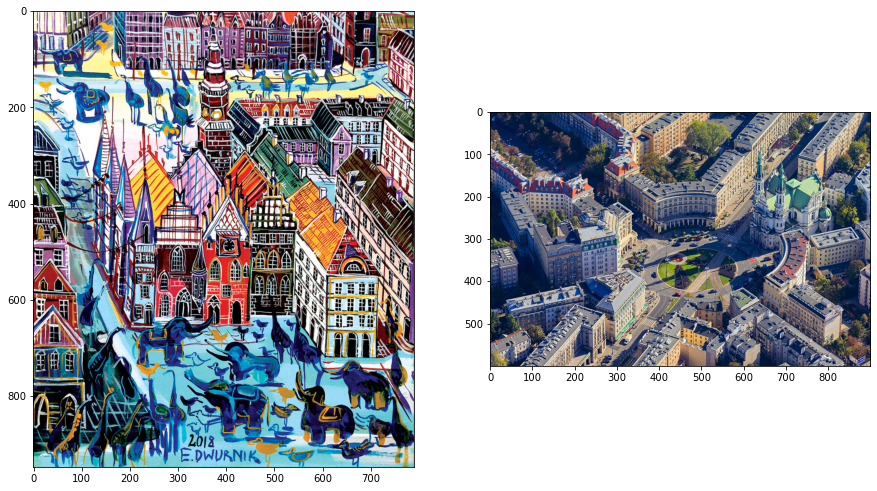

In [4]:
# load and disply images 
plac_zbawiciela_dwur_img = load_image(plac_zbawiciela_dwur_loc)
plac_zbawiciela_real_img = load_image(plac_zbawiciela_real_loc)

print(plac_zbawiciela_dwur_img.shape)
print(plac_zbawiciela_real_img.shape)

plot_images([plac_zbawiciela_dwur_img, plac_zbawiciela_real_img])

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


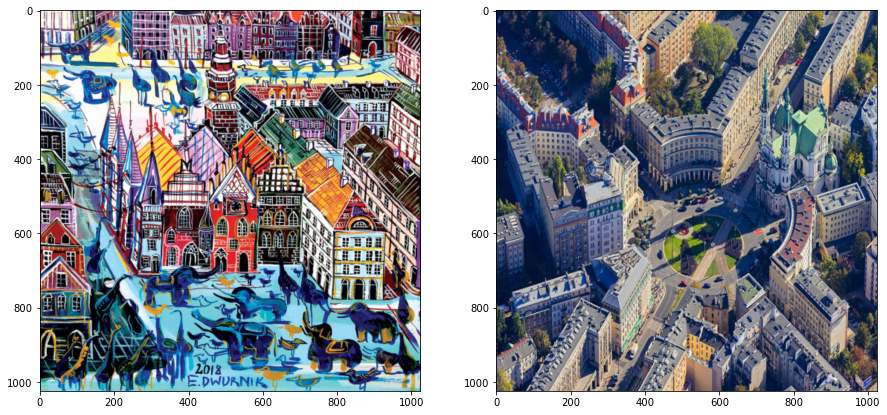

In [43]:
# obcięcie rozmiaru zdjęć do kwadratu i zmniejszenie
plac_zbawiciela_real_img = cv2.resize(plac_zbawiciela_real_img, 
                                      (1024,1024), interpolation = cv2.INTER_AREA)
#plac_zbawiciela_real_img = plac_zbawiciela_real_img[0:512,0:512,:]
#plac_zbawiciela_dwur_img = plac_zbawiciela_dwur_img[0:2000,460:2460,:]
plac_zbawiciela_dwur_img = cv2.resize(plac_zbawiciela_dwur_img, 
                                      (1024,1024), interpolation = cv2.INTER_AREA)
                                      
print(plac_zbawiciela_dwur_img.shape)
print(plac_zbawiciela_real_img.shape)

#plac_zbawiciela_dwur_img = np.array(plac_zbawiciela_dwur_img.resize((500,500)))

print(plac_zbawiciela_dwur_img.shape)

plot_images([plac_zbawiciela_dwur_img, plac_zbawiciela_real_img])

In [44]:
# import i uruchomienie modelu 
base_model = vgg19.VGG19(include_top=False, weights='imagenet')
print(base_model.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

#### Sprawdzenie jak będzie wyglądał przetworzony obraz

In [45]:
# dwa obrzy są używane, jeden to style [obraz artysty], a drugi to content [przetwarzane zdjęcie]
style_image = plac_zbawiciela_dwur_img
content_image = plac_zbawiciela_real_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 1024, 1024, 3)
(1024, 1024, 3)
<class 'numpy.ndarray'>


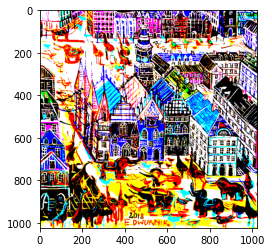

In [46]:
# sprawdzenie przetwarzania któe wykonuje sieć
process_example_img = vgg19.preprocess_input(np.expand_dims(style_image, axis=0))
print(process_example_img.shape)
print(process_example_img[0].shape)
print(type(process_example_img))

plt.imshow(process_example_img[0])

# jest ok, dodaliśmy jeden wymiar do obrazu, sztucznie bo sieć wymaga dodatkowych wejść, 
# widać jednak, że zmieniły się bardzo kolory, i taki zmienionybędzie obraz wyjściowy, 
# po pierwsze mamy zastosowane do kanałów koloru biasy, dodatkowo, zmieniana jest RGB na BGR
# od razu warto dopisać funkcję odwracającą zmiany kolorów

In [47]:
# sprawdzenie wartości biasów
VGG_BIASES = vgg19.preprocess_input((np.zeros((3))).astype("float32"))
# funkcja deprocessu
def deprocess (start_image):
    fin_image = start_image - VGG_BIASES
    fin_image = tf.unstack(fin_image,axis=-1)
    fin_image = tf.stack([fin_image[2],fin_image[1],fin_image[0]],axis=-1)
    return fin_image

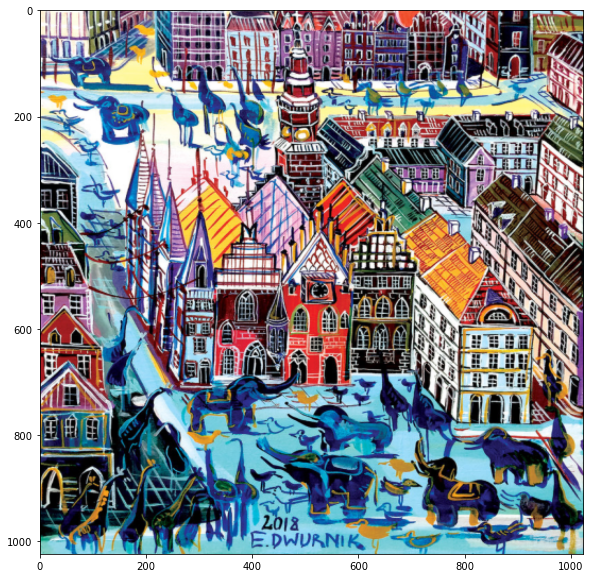

In [48]:
# sprawdzenie działania funkcji odwracającej działanie sieci na obrazie wyjściowym
plt.figure(figsize=(10,10))
plt.imshow(deprocess(process_example_img[0])/255)

### Tworzenie modelu to pobrania stylu 
W modelu style transfer po wstepnym nauczeniu sieci stosujemy sieć i jej części gdzie zapisane są cechy główne do zmiany obrau wejściowego. Ta operacja powtarza się wielokrotnie.

In [49]:
CONTENT_LAYERS = ["block5_conv2"] # przykładowa warstwa z której pobierzemy kontent po jednym obrocie
STYLE_LAYERS = ["block4_conv1",
                "block4_conv2",
                "block4_conv3",
                "block4_conv4"] # te warstwy zawierają cechy stylu

In [50]:
# zdefiniowanie modeli do testów, pełnego VGG19, bez pierwszych warstw i dla różnych rozmiarów
def make_model(full=False, in_shape=None):
    if full:    
        base_model = vgg19.VGG19(inclued_top=True, weights='imegenet')
        return base_model
    if in_shape != None:
        base_model = vgg19.VGG19(inclued_top=False, input_shape=in_shape, weights='imegenet')
    else:
        base_model=vgg19.VGG19(include_top=False,weights="imagenet")
    # w metodzie style transfer, optymalizację nie wykonujemy na modelu, ale na obrazie transformowanym 
    base_model.trainable = False
    content_layers = CONTENT_LAYERS
    style_layers = STYLE_LAYERS
    output_layers = [base_model.get_layer(layer).output for layer in (content_layers+style_layers)]
    return tf.keras.models.Model(base_model.input,output_layers)

In [51]:
# stworzenie modelu 
base_model = make_model()

In [52]:
# aby użyć przerobionego modelu VGG19 należy na wejścia podać przeprocesowane obrazy 
processed_dwur_img = vgg19.preprocess_input(np.expand_dims(plac_zbawiciela_dwur_img, axis = 0))
processed_real_img = vgg19.preprocess_input(np.expand_dims(plac_zbawiciela_real_img, axis = 0))

In [53]:
# otrzymanie pierwszych danych wyjściowych
outputs_dwur_img = base_model(processed_dwur_img)
outputs_real_img = base_model(processed_real_img)

In [54]:
# wyciągnięcie odpowiednichcech stylu z obrazów
content_dwur_img = outputs_dwur_img[0]
content_real_img = outputs_real_img[0]

#### Teraz nalezy zbudować odpowiednią funkcję porównania stylu i kontentu 
użyta zostanie tutaj macierz Gramma do różnicy styli obu obrazów oraz zwykła MSE do różnicy kontentów
MSE ma posłóżyć zachowaniu oryginalnego wyglądu kontentu (np. pies ma zostać psem, ale o zmienionym stylu)

In [55]:
# funkcja straty kontentu między dwoma obrazami MSE
def content_loss(img_new, img_base):
    return np.mean(np.square(img_new - img_base))

In [56]:
# funkcja straty stylu, implementację wziąłem z internetu
# w skrócie macierz Gramma to macierz wszystkich możliwych relacji między cechami obrazu
def gram_matrix(output):
    first_style_layer = output
    A = tf.reshape(first_style_layer,(-1,first_style_layer.shape[-1]))
    n = A.shape[0]
    gram_matrix = tf.matmul(A,A,transpose_a = True)
    n = gram_matrix.shape[0]
    return gram_matrix/tf.cast(n,"float32"),n

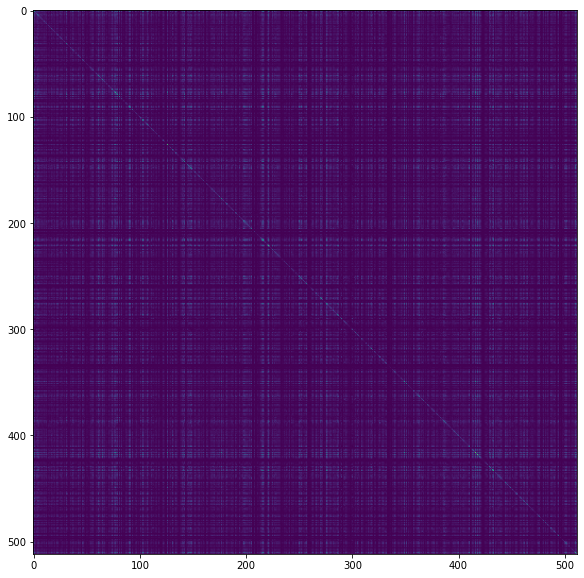

In [57]:
# Macierz dla warstw styli które wyciągnęliśmy z obrazu stylu
gram_matrix_img, N = gram_matrix(outputs_dwur_img[2])

plt.figure(figsize=(10,10))
plt.imshow(gram_matrix_img.numpy())

In [58]:
def style_loss(style_new, style_base):
    style_new_gram, gram_height1 = gram_matrix(style_new)
    style_base_gram, gram_height2 = gram_matrix(style_base)
    assert gram_height1 == gram_height2
    num_features = style_new_gram.shape[0]
    loss = tf.reduce_sum(tf.square(style_base_gram-style_new_gram)/(4*int(gram_height1)**2)*(int(num_features)**2))
    return loss
    

In [59]:
# połącznie błędu kontentu i stylu 
# współczynnik pozwoli na dopasowanie stosunku wagi stylu do zachowania kontentu
def total_loss(new_image_output,base_content_image_output,base_style_image_output,alpha=.999):
    new_image_styles = new_image_output[len(CONTENT_LAYERS):]
    base_image_styles = base_style_image_output[len(CONTENT_LAYERS):]
    style_loss_val = 0
    N = len(new_image_styles)
    for i in range(N):
        style_loss_val += style_loss(new_image_styles[i], base_image_styles[i])   
    
    new_image_contents = new_image_output[:len(CONTENT_LAYERS)]
    base_image_contents = base_content_image_output[:len(CONTENT_LAYERS)]
    content_loss_val = 0
    N = len(new_image_contents)
    for i in range(N):
        content_loss_val += content_loss(new_image_contents[i],base_image_contents[i])/N
    
    return (1-alpha)*style_loss_val+alpha*content_loss_val

In [60]:
# strata przetworzenia pierwszej rotacji 
total_loss(outputs_dwur_img, outputs_real_img, outputs_dwur_img)

<tf.Tensor: id=1344774, shape=(), dtype=float32, numpy=11086.064>

### Training
Po przygotowaniu wszystkich elementów można uruchomić procedurę przetwarzania obrazu 

In [61]:
base_style_outputs = base_model(processed_dwur_img)
base_content_outputs = base_model(processed_real_img)

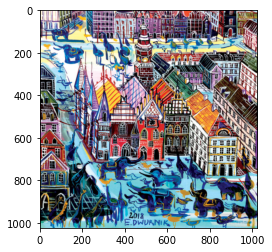

In [62]:
plt.imshow(deprocess(processed_dwur_img[0])/255)

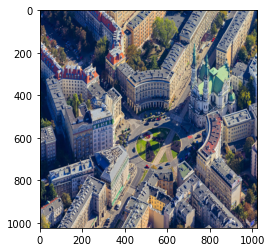

In [63]:
plt.imshow(deprocess(processed_real_img[0])/255)

In [64]:
# !!!! Można spróbować dodać trochę szumu do tego, żeby obraz lepiej poddał się content loss !!!!!
# +tf.random.normal(processed_real_img.shape)
processed_content_var = tf.Variable(processed_real_img+tf.random.normal(processed_real_img.shape))

In [65]:
optimizer = tf.keras.optimizers.Adam(5, beta_1=.99, epsilon=1e-3)

In [66]:
from IPython.display import display,clear_output

In [67]:
images = []
losses = []
i = 0 
# na początek coś dużego, tak o dla ogarnięcia jak to wyjdzie
best_loss = 200000
min_vals = VGG_BIASES
max_vals = VGG_BIASES + 255

for i in range(10000):
    with tf.GradientTape() as tape:
        tape.watch(processed_content_var)
        content_var_outputs = base_model(processed_content_var)
        loss = total_loss(content_var_outputs,base_content_outputs,base_style_outputs,alpha=.9999)
        grad = tape.gradient(loss,processed_content_var)
        losses.append(loss)
        optimizer.apply_gradients(zip([grad],[processed_content_var]))
        # obcinamy do wartości dopuszczalnych, po deprocessingu muszą być rozpownawalne
        clipped = tf.clip_by_value(processed_content_var, min_vals, max_vals)
        processed_content_var.assign(clipped)       
        if i%5 == 0:
            images.append(deprocess(processed_content_var))
        if loss < best_loss:
            # nadajemy nowy loss jako best i przypisujemy best_img
            best_image = processed_content_var
            best_loss=loss
        clear_output(wait=True)
        print(loss)
        print(i)

tf.Tensor(536897750000.0, shape=(), dtype=float32)
2465


KeyboardInterrupt: 

In [68]:
len(images)

494

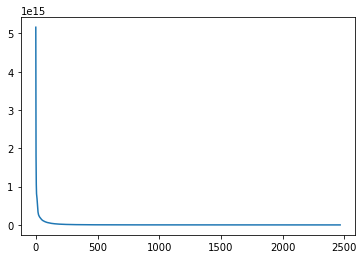

In [69]:
plt.plot(losses)

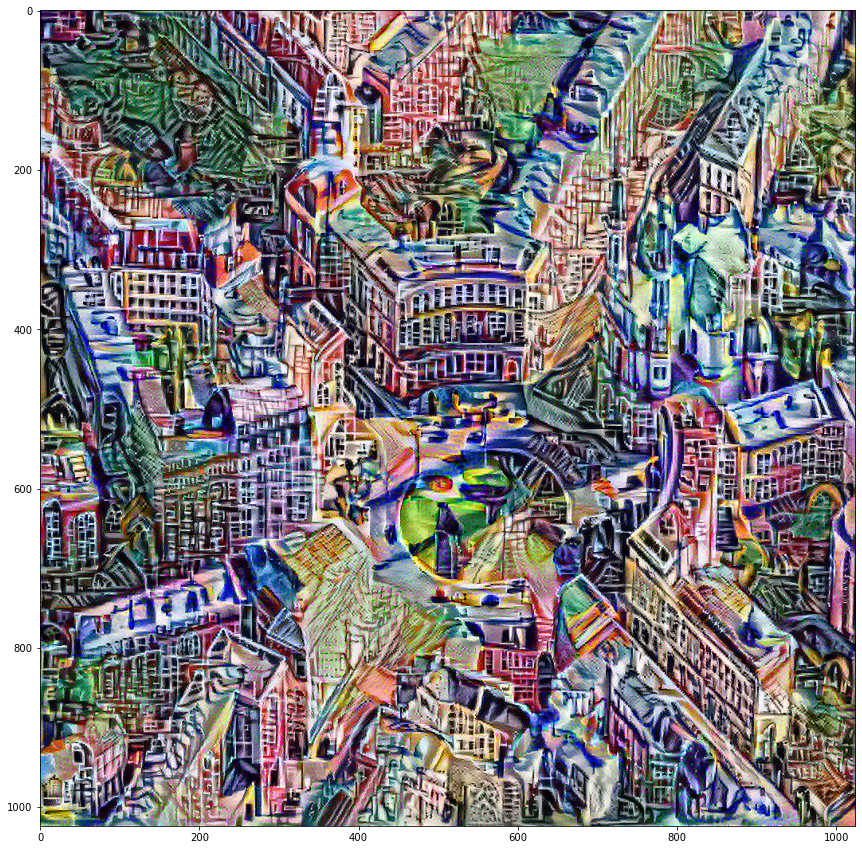

In [73]:
image_deproc = images[490][0]

plt.figure(figsize=(15,15))
plt.imshow(image_deproc/255)

In [132]:
from matplotlib.animation import FuncAnimation

In [160]:
fig, ax = plt.subplots(ncols = 3,nrows = 1,figsize = (45,15))
def update(i):
    im_normed = images[i].numpy().reshape((512,512,3))/255
    ax[0].imshow(im_normed)
    ax[1].imshow(plac_zbawiciela_real_img)
    ax[2].imshow(plac_zbawiciela_dwur_img)
    ax[0].set_title("Loss: {:.4e}, {}".format(losses[i], i), fontsize=20)
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()
    print(i)
anim = FuncAnimation(fig, update, frames=np.arange(0, len(images)), interval=10)
anim.save('c:/Users/moko/Desktop/Dwurnik_PlZbaw_7500.gif', dpi=80, writer='ffmpeg')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000021CED80F488> (for post_execute):


KeyboardInterrupt: 

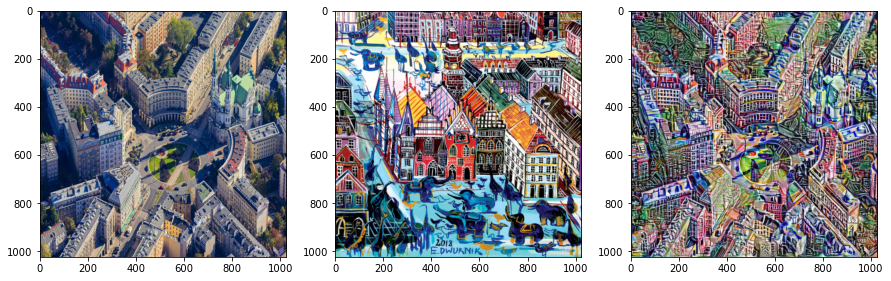

In [74]:
plot_images([plac_zbawiciela_real_img ,plac_zbawiciela_dwur_img, image_deproc/255])